**Importing the necessary dependencies**

In [1]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms

**Setting up random seed generator**

In [2]:
torch.manual_seed(111)

In [3]:
device=""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

**Preparing the Training Data**

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))]
)

In [5]:
#Downloading the MNIST dataset
train_set = torchvision.datasets.MNIST(
    root=".", train=True, download=True, transform=transform
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [6]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

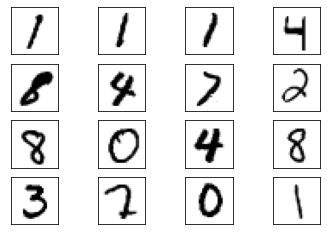

In [7]:
#Plotting samples of training data
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
  ax = plt.subplot(4, 4, i+1)
  plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
  plt.xticks([])
  plt.yticks([])

**Implementing the Discriminator and Generator**

In [8]:
#Discriminator is MLP neural network receives 28x28 pixel image
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(784, 1024),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(256, 1),
        nn.Sigmoid(),
    )

  def forward(self, x):
    x = x.view(x.size(0), 784)
    output = self.model(x)
    return output

In [9]:
discriminator = Discriminator().to(device=device)

In [10]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

In [11]:
generator = Generator().to(device=device)

**Training the Models**

In [12]:
lr=0.0001
num_epochs = 50
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [13]:
for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(
            device=device
        )
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(
            device=device
        )
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels
        )
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.5692477226257324
Epoch: 0 Loss G.: 0.4779079854488373
Epoch: 1 Loss D.: 0.06096680834889412
Epoch: 1 Loss G.: 3.8333747386932373
Epoch: 2 Loss D.: 0.011416684836149216
Epoch: 2 Loss G.: 5.403036594390869
Epoch: 3 Loss D.: 0.04152332618832588
Epoch: 3 Loss G.: 5.134734630584717
Epoch: 4 Loss D.: 0.006647448055446148
Epoch: 4 Loss G.: 6.727372169494629
Epoch: 5 Loss D.: 0.08717642724514008
Epoch: 5 Loss G.: 4.58128547668457
Epoch: 6 Loss D.: 0.1770595908164978
Epoch: 6 Loss G.: 3.0975842475891113
Epoch: 7 Loss D.: 0.06646732240915298
Epoch: 7 Loss G.: 3.1782543659210205
Epoch: 8 Loss D.: 0.16090232133865356
Epoch: 8 Loss G.: 2.8278183937072754
Epoch: 9 Loss D.: 0.4348783791065216
Epoch: 9 Loss G.: 2.3554561138153076
Epoch: 10 Loss D.: 0.3388947546482086
Epoch: 10 Loss G.: 1.9112112522125244
Epoch: 11 Loss D.: 0.38758739829063416
Epoch: 11 Loss G.: 1.5978403091430664
Epoch: 12 Loss D.: 0.2804984450340271
Epoch: 12 Loss G.: 1.3075517416000366
Epoch: 13 Loss D.: 0.288892

**Checking samples generated by GAN**

In [14]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
genearted_samples = generator(latent_space_samples)

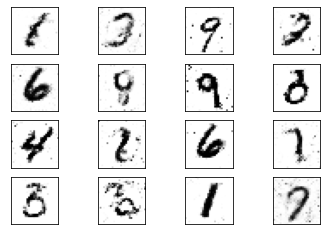

In [15]:
generated_samples = generated_samples.cpu().detach()
for i in range(16):
  ax = plt.subplot(4, 4, i+1)
  plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
  plt.xticks([])
  plt.yticks([])